Monte Carlo with 1000000 simulations equals to ):, 8621.917351351574
Quadrature Value:8622.6293



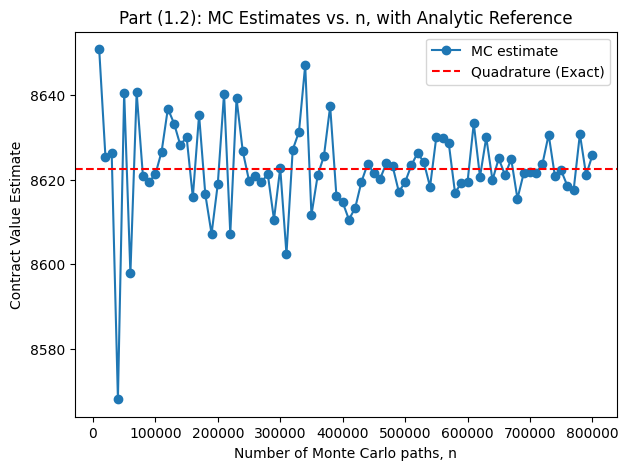

In [73]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats.qmc import Halton
from scipy.stats import norm

# Defining parameters of the European financial contract

S0 = 7496.62
T = 1.75
t = 0
theta = 7491.53
alpha = 0.04
beta = 0.01
gamma = 0.9
sigma = 0.23
X2 = 8500
X1 = 7500
r = 0.01

# Monte Carlo sample sizes 
N = [10000*(k+1) for k in range(80)]  

#Computing the S0 and V0 values

def f_ST(S0, theta, alpha, beta, T):
    return S0 * np.sin(beta*T - 2*alpha*T) + theta*(3 -  np.exp(alpha*T) - np.exp(beta*T))

def v_ST(S0, theta, sigma, beta, gamma, T):
    return sigma * (1 + beta*T) * (S0*theta)**(1/(2*gamma))

# Computation of the actual values
f_val = f_ST(S0, theta, alpha, beta, T)
v_val = v_ST(S0, theta, sigma, beta, gamma, T)

# Defining the payoff function

def payoff(S):
    if S < X1:
        return X2 - S
    elif S < X2:
        return X2
    else:
        return S

 #Run the Monte-Carlo valuation   

def monte_carlo_value(N, seed=None):
    Z = np.random.normal(0, 1 , N)
    S_T = f_val + v_val * np.sqrt(T)*Z
    
    payoffs = np.array([payoff(s) for s in S_T])
    
    return np.exp(-r*T)*payoffs.mean()

# 5) Numerical Quadrature

def integrand(x):
    std = v_val*np.sqrt(T)
    pdf = (1 / (std *np.sqrt(2*np.pi))) * \
          np.exp(-0.5*((x - f_val)/std)**2)
    
    return payoff(x)*pdf

def quadrature_value():
    # Integrate the function.
    val, _ = quad(integrand, -np.inf, np.inf)
    return np.exp(-r*T)*val

# Monte Carlo estimate
N_mc = 1_000_000
mc_val = monte_carlo_value(N_mc, seed=1234)  

# (B) Quadrature (numerical integration) "analytic" solution
quad_val = quadrature_value()

print(f"Monte Carlo with {N_mc} simulations equals to ):, {mc_val:}")
print(f"Quadrature Value:{quad_val:0.4f}\n")


# Prepare the plotting

mc_estimates = []
for n in N:
    val_n = monte_carlo_value(n)  
    mc_estimates.append(val_n)

# Plot
plt.figure(figsize=(7,5))
plt.plot(N, mc_estimates, marker='o', linestyle='-', label='MC estimate')
plt.axhline(y=quad_val, linestyle='--', label='Quadrature (Exact)', color='red')
plt.xlabel('Number of Monte Carlo paths, n')
plt.ylabel('Contract Value Estimate')
plt.title('Part (1.2): MC Estimates vs. n, with Analytic Reference')
plt.legend()



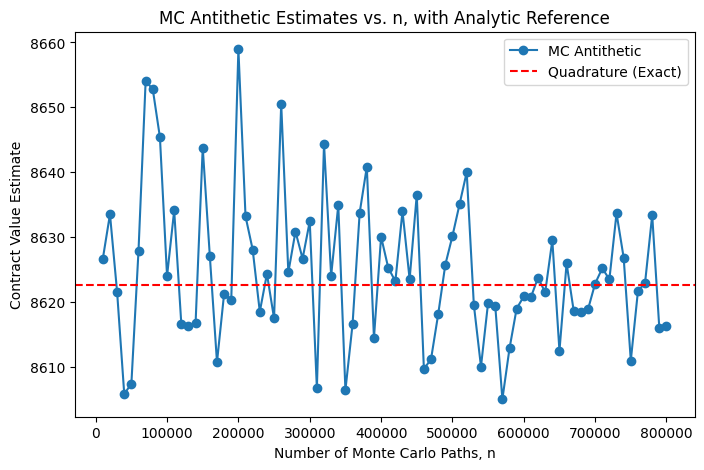

In [74]:
# Monte Carlo valuation using antithetic variables

def monte_carlo_antithetic(N):
    Z = np.random.normal(0, 1, N // 2)  
    Z_antithetic = -Z  
    
    S_T1 = f_val + v_val * np.sqrt(T) * Z
    S_T2 = f_val + v_val * np.sqrt(T) * Z_antithetic
    
    payoffs1 = np.array([payoff(s) for s in S_T1])
    payoffs2 = np.array([payoff(s) for s in S_T2])
    
    payoffs = (payoffs1 + payoffs2) / 2  
    
    return np.exp(-r * T) * np.mean(payoffs)

# Compare Monte Carlo estimates with increasing N
N_values = [10000 * (k + 1) for k in range(80)]
mc_antithetic_estimates = []
time_antithetic = []

for n in N_values:
    start_time = time.time()
    estimate = monte_carlo_antithetic(n)
    mc_antithetic_estimates.append(estimate)
    time_antithetic.append(time.time() - start_time)

# Plot Monte Carlo Antithetic vs Quadrature
plt.figure(figsize=(8, 5))
plt.plot(N_values, mc_antithetic_estimates, marker='o', linestyle='-', label='MC Antithetic')
plt.axhline(y=quad_val, linestyle='--', label='Quadrature (Exact)', color='red')
plt.xlabel('Number of Monte Carlo Paths, n')
plt.ylabel('Contract Value Estimate')
plt.title('MC Antithetic Estimates vs. n, with Analytic Reference')
plt.legend()



Moment-Matching sampling

Quadrature Value: 8622.6293
Moment Matching Monte Carlo Estimate (N=800000): 8626.0862


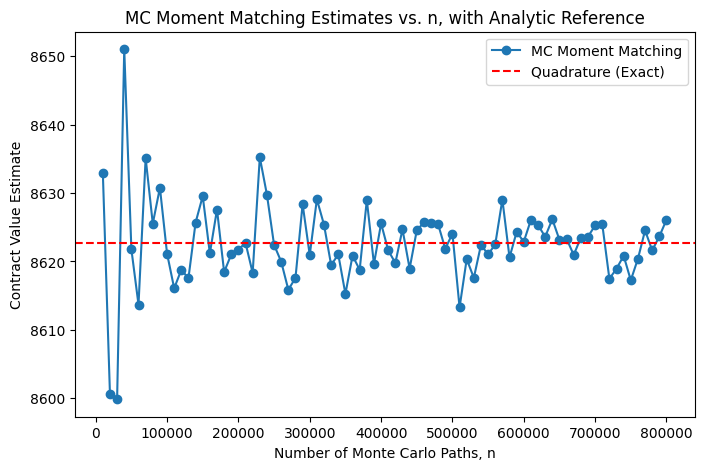

In [75]:
# Monte Carlo valuation using moment matching
def monte_carlo_moment_matching(N):
    Z = np.random.normal(0, 1, N)  
    
    Z = (Z - np.mean(Z)) / np.std(Z)
    
    S_T = f_val + v_val * np.sqrt(T) * Z
    payoffs = np.array([payoff(s) for s in S_T])
    
    return np.exp(-r * T) * np.mean(payoffs)
    
# Compare Monte Carlo estimates with increasing N
N_values = [10000 * (k + 1) for k in range(80)]
mc_moment_matching_estimates = []

for n in N_values:
    estimate = monte_carlo_moment_matching(n)
    mc_moment_matching_estimates.append(estimate)


# Plot Monte Carlo Moment Matching vs Quadrature
plt.figure(figsize=(8, 5))
plt.plot(N_values, mc_moment_matching_estimates, marker='o', linestyle='-', label='MC Moment Matching')
plt.axhline(y=quad_val, linestyle='--', label='Quadrature (Exact)', color='red')
plt.xlabel('Number of Monte Carlo Paths, n')
plt.ylabel('Contract Value Estimate')
plt.title('MC Moment Matching Estimates vs. n, with Analytic Reference')
plt.legend()
print(f"Quadrature Value: {quad_val:.4f}")
print(f"Moment Matching Monte Carlo Estimate (N={N_values[-1]}): {mc_moment_matching_estimates[-1]:.4f}")


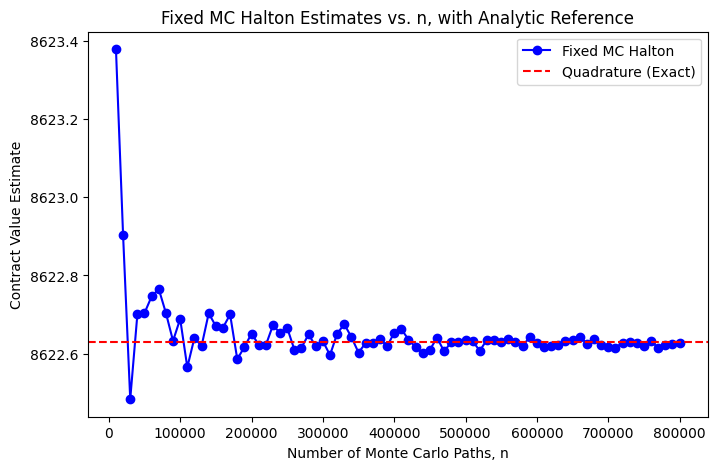

In [77]:
# Halton sequence

def monte_carlo_halton_fixed(N):
    halton_sampler = Halton(d=1, scramble=False)  
    halton_samples = halton_sampler.random(n=N).flatten()  
    halton_samples = (halton_samples * (1 - 1e-10)) + 1e-10
    
    Z = norm.ppf(halton_samples)
    
    S_T = f_val + v_val * np.sqrt(T) * Z
    payoffs = np.array([payoff(s) for s in S_T])
    
    return np.exp(-r * T) * np.mean(payoffs)

# Compare Monte Carlo estimates with increasing N
mc_halton_fixed_estimates = []
time_halton_fixed = []

for n in N_values:
    estimate = monte_carlo_halton_fixed(n)
    mc_halton_fixed_estimates.append(estimate)



# Plot Monte Carlo Halton vs Quadrature after Fix
plt.figure(figsize=(8, 5))
plt.plot(N_values, mc_halton_fixed_estimates, marker='o', linestyle='-', label='Fixed MC Halton', color='blue')
plt.axhline(y=quad_val, linestyle='--', label='Quadrature (Exact)', color='red')
plt.xlabel('Number of Monte Carlo Paths, n')
plt.ylabel('Contract Value Estimate')
plt.title('Fixed MC Halton Estimates vs. n, with Analytic Reference')
plt.legend()


Task 2: Path Dependent Options

In [80]:
# Setting the parametres

S0 = 64956.45
T = 0.75
theta = 64912.2
alpha = 0.05
beta = 0.01
gamma = 0.92
sigma = 0.3
r = 0.01
K = 50
strike = 65000
n_paths = 1000000

Task 2: Different simulations

Estimated Asian Call Option Price: 2119.5500


Text(0.5, 1.0, 'Convergence of discrete Asian call price with increasing N')

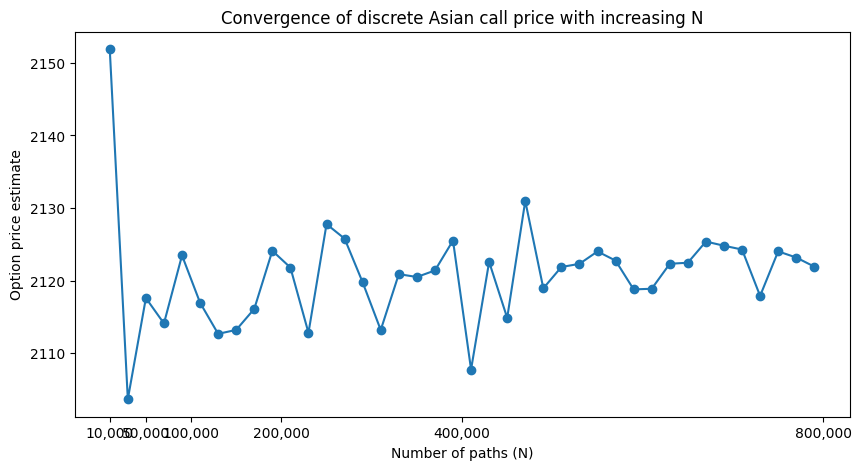

In [89]:
def simulate_paths(n_paths,K,T,S0,alpha,beta,gamma,theta, sigma,r):

    dt = T / K
    # Preallocate array for simulated paths
    S = np.zeros((n_paths, K+1))
    S[:, 0] = S0
    
    # Simulate paths
    for k in range(1, K+1):
        z = np.random.randn(n_paths)
        
        S_prev = S[:, k-1]
        
        # Compute Drift and diffusion terms
        drift = (alpha * theta - beta * S_prev) * dt
        diffusion = sigma * (np.abs(S_prev)**gamma) * np.sqrt(dt) * z
        
        S[:, k] = S_prev + drift + diffusion
    
    return S

def price_discrete_asian_call(n_paths,K,T,S0,alpha,beta,gamma,theta,sigma,r, strike):

    S = simulate_paths(n_paths, K, T, S0, alpha, beta, gamma, theta, sigma, r)
    
    A = np.mean(S[:, 1:], axis=1)   
    
    # Payoff for each path
    payoff = np.maximum(A - strike, 0)
    
    # Discounted average payoff
    price_estimate = np.exp(-r * T) * np.mean(payoff)
    return price_estimate

option_price = price_discrete_asian_call(n_paths,K,T,S0,alpha,beta,gamma,theta,sigma,r,strike)
print(f"Estimated Asian Call Option Price: {option_price:.4f}")

# Chooising a range of path counts
path_counts = list(range(10000, 800000, 20000))
estimates = []

for n in path_counts:
    est = price_discrete_asian_call(n, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike)
    estimates.append((n, est,))

# Extract values for plotting
Ns = [item[0] for item in estimates]
Prices = [item[1] for item in estimates]

# Define tick values (explicitly choosing key points)
tick_values = [10000, 50000, 100000, 200000, 400000, 800000]

# Plot the results
plt.figure(figsize=(10, 5))  
plt.plot(Ns, Prices, marker='o')
plt.xticks(tick_values, [f"{x:,}" for x in tick_values])  
plt.xlabel("Number of paths (N)")
plt.ylabel("Option price estimate")
plt.title("Convergence of discrete Asian call price with increasing N")


Task 2.3: estimating the value of the partial derivative

Halton sequence for the Asian option

In [95]:
#Halton sequence for Asian options
def monte_carlo_halton_asian(n_paths, gamma):
    halton_sampler = Halton(d=K, scramble=False)  
    halton_samples = halton_sampler.random(n=n_paths)  
    halton_samples = (halton_samples * (1 - 1e-10)) + 1e-10

    # Inverse CDF 
    Z = norm.ppf(halton_samples)  

    # Time step
    dt = T / K

    # Simulating asset paths 
    S = np.zeros((n_paths, K+1))  
    S[:, 0] = S0  

    for k in range(1, K+1):
        S_prev = S[:, k-1]
        drift = (alpha * theta - beta * S_prev) * dt
        diffusion = sigma * (np.abs(S_prev) ** gamma) * np.sqrt(dt) * Z[:, k-1] 
        S[:, k] = S_prev + drift + diffusion

    # Compute arithmetic mean of asset prices
    A = np.mean(S[:, 1:], axis=1)

    # Calculating the payoffs
    payoffs = np.maximum(A - strike, 0)

    # discounting expected payoff
    return np.exp(-r * T) * np.mean(payoffs)

# Compute the Asian option price using Halton sequences
x = monte_carlo_halton_asian(n_paths, gamma)

# Print the result
print(f"The price of the Asian call option with Halton sequences equals: {x:.4f}")


The price of the Asian call option with Halton sequences equals: 2107.7113


In [123]:
# Estimate the small change (dgamma) for the option price

dgamma = 1e-3  

def estimate_gamma_sensitivity(n_paths, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike, dgamma):

    # Compute option price 
    V_original = price_discrete_asian_call(n_paths, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike)

    # Calculate the  option price at gamma + dgamma 
    V_modified = price_discrete_asian_call(n_paths, K, T, S0, alpha, beta, gamma + dgamma, theta, sigma, r, strike)

    # Compute finite difference for dgamma
    dV_dgamma = (V_modified - V_original) / dgamma
    
    return V_original, V_modified, dV_dgamma

#Compute sensitivity of option price to gamma
V_original, V_modified, dV_dgamma = estimate_gamma_sensitivity(n_paths, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike, dgamma)

# Print results
print(f"Option price at y = {gamma:.5f}: {V_original:.4f}")
print(f"Option price at y + Δγ = {gamma + dgamma:.5f}: {V_modified:.4f}")
print(f"Estimated sensitivity dV/dγ ≈ {dV_dgamma:.4f}")


Option price at y = 0.92000: 2111.5142
Option price at y + Δγ = 0.92100: 2129.4358
Estimated sensitivity dV/dγ ≈ 17921.6218


Enhancement of the analysis 

Text(0.5, 1.0, 'Standard Monte Carlo Sensitivity Analysis ')

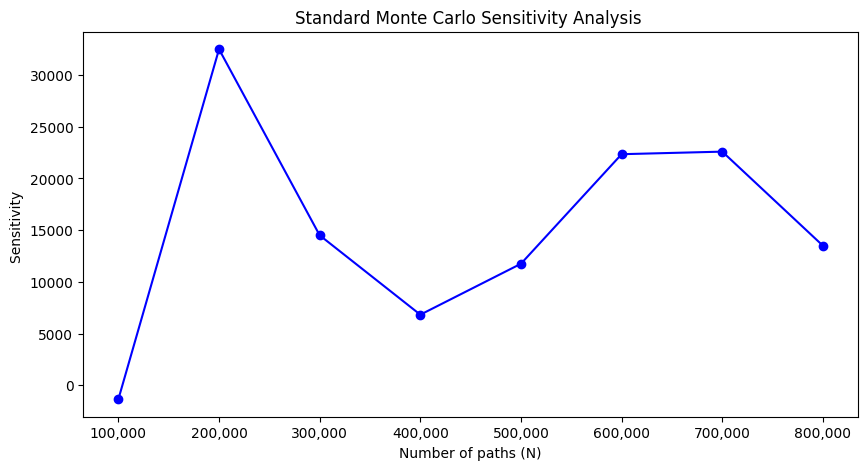

In [124]:
# Choosing a range of path counts
path_counts = list(range(100000, 810000, 100000))  
sensitivity_results = []

for n in path_counts:

    # Compute the sensitivity 
    V_g, V_gp, dVdg = estimate_gamma_sensitivity(n, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike, dgamma)

    # Store only the derivative estimate
    sensitivity_results.append((n, dVdg))

# Extract values for plotting
Ns = [item[0] for item in sensitivity_results]  
Sensitivities = [item[1] for item in sensitivity_results]  

# Define proper tick values
tick_values = path_counts  

# Plot the results
plt.figure(figsize=(10, 5))  
plt.plot(Ns, Sensitivities, marker='o', linestyle='-', color='b')
plt.xticks(tick_values, [f"{x:,}" for x in tick_values])  
plt.xlabel("Number of paths (N)")
plt.ylabel("Sensitivity ")
plt.title("Standard Monte Carlo Sensitivity Analysis ")


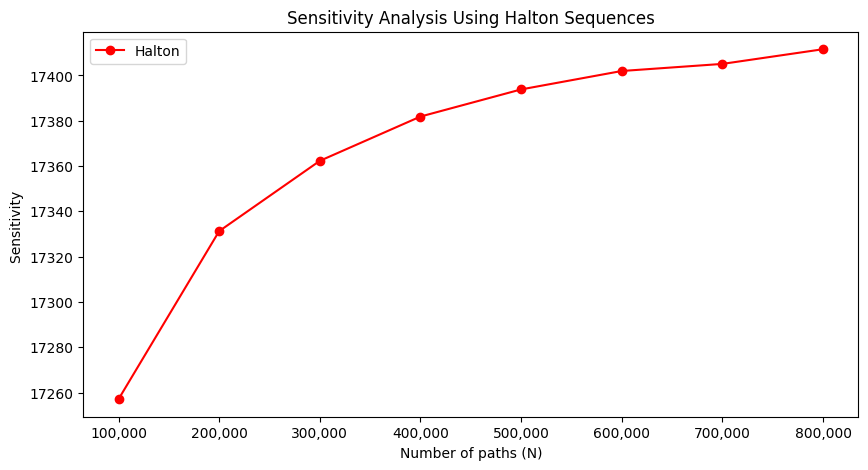

In [54]:
def estimate_gamma_sensitivity_halton(n_paths, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike, dgamma):

    # Compute V(gamma) using Halton sequences
    V_gamma = monte_carlo_halton_asian(n_paths, gamma)

    # Compute V(gamma + dgamma) using Halton sequences
    V_gamma_plus = monte_carlo_halton_asian(n_paths, gamma + dgamma)

    # Compute finite difference approximation
    dV_dgamma = (V_gamma_plus - V_gamma) / dgamma

    return V_gamma, V_gamma_plus, dV_dgamma

# Sensitivity Analysis 

sensitivity_results_halton = []

for n in path_counts:
    # Compute sensitivity using Halton-based function
    V_g, V_gp, dVdg = estimate_gamma_sensitivity_halton(n, K, T, S0, alpha, beta, gamma, theta, sigma, r, strike, dgamma)

    # Store only the derivative estimate
    sensitivity_results_halton.append((n, dVdg))

# Extract values for plotting
Ns_halton = [item[0] for item in sensitivity_results_halton]  
Sensitivities_halton = [item[1] for item in sensitivity_results_halton]  

# Define proper tick values
tick_values = path_counts  

# Plot the results
plt.figure(figsize=(10, 5))  
plt.plot(Ns_halton, Sensitivities_halton, marker='o', linestyle='-', color='r', label='Halton')
plt.xticks(tick_values, [f"{x:,}" for x in tick_values])  
plt.xlabel("Number of paths (N)")
plt.ylabel("Sensitivity ")
plt.title("Sensitivity Analysis Using Halton Sequences")
plt.legend()
